## Introduction

In this notebook you will learn about the **AR-CNN** - a novel self-correcting, autoregressive model that uses a convolutional neural network in its architecture. By the end of this notebook, you will have trained and ran inference on your very own custom model. This notebook dives into details on the model and assumes a moderate level of understanding of machine learning concepts; as a result, we encourage you to read the introductory [learning capsules](https://console.aws.amazon.com/deepcomposer/home?region=us-east-1#learningCapsules) before going through this notebook.

Traditionally, there have been two primary approaches to generating music with deep neural network-based generative models. One treats music generation as an image generation problem,
while the other treats music as a time series generation problem analogous to autoregressive language modeling. The AR-CNN model uses elements from both approaches to generate music. We view each piece of music as a piano roll (an image representation of music), but generate each note (i.e. pixel) autoregressively.

Generating images autoregressively has been an area of interest to researchers. 
* Orderless NADE showcased an approach to generating images assuming ordering-invariance in the next pixel to be added.  
* PixelCNN demonstrated with a fixed row by row ordering that an autoregressive approach can generate convincing results for CIFAR-10.

In the music domain, CocoNET - the algorithm behind Google’s Bach Doodle - adopts an approach similar to orderless NADE, but using Gibbs Sampling to obtain inference results. 

One common theme with autoregressive approaches, however, is that they are very prone to accumulation of error. Our approach is novel in that the model is trained to detect mistakes - including those it made itself - and fix them. We do this by viewing music generation as a series of **edit events** which can be either the addition of a new note or removal of an existing note. An **edit sequence** is a series of **edit events** and every edit sequence can directly correspond to a piece of music. By training our model to view the problem as edit events rather than as an entire image or just the addition of notes, we found that our model is able to offset accumulation of error and generate higher quality music. We won’t go too deep into the math in this notebook, but please check out our paper **HERE** for a more mathematically rigorous definition.

Now that you understand the basic theory behind our approach, let’s dive into the practical code. In the next section we discuss and show examples using the piano roll format.

## Dependencies
First, let's install and import all of the python packages we will use throughout the tutorial.


In [1]:
# The MIT-Zero License

# Copyright 2020 Amazon.com, Inc. or its affiliates. All Rights Reserved.

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.


# Create the environment and install required packages
!pip install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
# Imports
import os
import glob
import json
import numpy as np
import keras
from enum import Enum
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from random import randrange
import random
import math
import pypianoroll
from utils.midi_utils import play_midi, plot_pianoroll, get_music_metrics, process_pianoroll, process_midi
from constants import Constants
from augmentation import AddAndRemoveAPercentageOfNotes
from data_generator import PianoRollGenerator
from utils.generate_training_plots import GenerateTrainingPlots
from inference import Inference

Using TensorFlow backend.


## Dataset Summary
In this tutorial, we use the [`JSB-Chorales-dataset`](http://www-etud.iro.umontreal.ca/~boulanni/icml2012), comprising 229 chorale snippets. A chorale is a hymn that is usually sung with a single voice playing a simple melody and three lower voices providing harmony. In this dataset, these voices are represented by four piano tracks.

In case, you want to train the ArCnn model on your own dataset, please replace the current **data_dir** path with your directory to midi files.
Let's listen to a song from this dataset.

In [3]:
# Get The List Of Midi Files
data_dir = 'data/*.mid'
midi_files = glob.glob(data_dir)
random_midi = randrange(len(midi_files))
play_midi(midi_files[random_midi])

## Data Format - Piano Roll

For the purpose of this tutorial, we represent music from the JSB-Chorales dataset in the piano roll format.


A **piano roll** is a discrete, image-like representation of music which can be viewed as a two-dimensional grid with **"Time"** on the horizontal axis and **"Pitch"** on the vertical axis. In our use case, the presence of a pixel in any particular cell in this grid indicates if a note was played or not at that time and pitch.
Let us look at a few piano rolls in our dataset. In this example, a single piano roll track has 128 discrete time steps and 128 pitches.

<img src="images/pianoroll.png" alt="Dataset summary" width="800">

ArCnn model when comes across midi files with multiple tracks, all the tracks are merged to form a single track and this can be visualized below.

<img src="images/merged_pianoroll.png" alt="Merged Piano roll" width="300">

You might notice this representation looks similar to an image. While the sequence of notes is often the natural way that people view music, many modern machine learning models instead treat music as images and leverage existing techniques within the computer vision domain. You will see such techniques used in our architecture later in this tutorial.

**Why 128 time steps?**

For the purpose of this tutorial, we sample eight non-empty bars (https://en.wikipedia.org/wiki/Bar_(music)) from each song in the JSB-Chorales dataset. A **bar** (or **measure**) is a unit of composition and contains four beats for songs in our particular dataset (our songs are all in 4/4 time) :

We’ve found that using a resolution of four time steps per beat captures enough of the musical detail in this dataset.

This yields...

$$ \frac{4\;timesteps}{1\;beat} * \frac{4\;beats}{1\;bar} * \frac{8\;bars}{1} = 128\;timesteps $$


## Create The Dataset

In [4]:
# Generate Midi File Samples
def generate_samples(midi_files, bars, beats_per_bar, beat_resolution, bars_shifted_per_sample):
    """
    dataset_files: All files in the dataset
    return: piano roll samples sized to X bars
    """
    timesteps_per_nbars = bars * beats_per_bar * beat_resolution
    time_steps_shifted_per_sample = bars_shifted_per_sample * beats_per_bar * beat_resolution
    samples = []
    for midi_file in midi_files:
        pianoroll = process_midi(midi_file, beat_resolution) # Parse the midi file and get the piano roll
        samples.extend(process_pianoroll(pianoroll, time_steps_shifted_per_sample, timesteps_per_nbars))
    return samples

In [5]:
# Convert Input Midi Files To Tensors
dataset_samples = generate_samples(midi_files, Constants.bars, Constants.beats_per_bar, 
                                   Constants.beat_resolution, 
                                   Constants.bars_shifted_per_sample)
# Shuffle The Dataset
random.shuffle(dataset_samples)

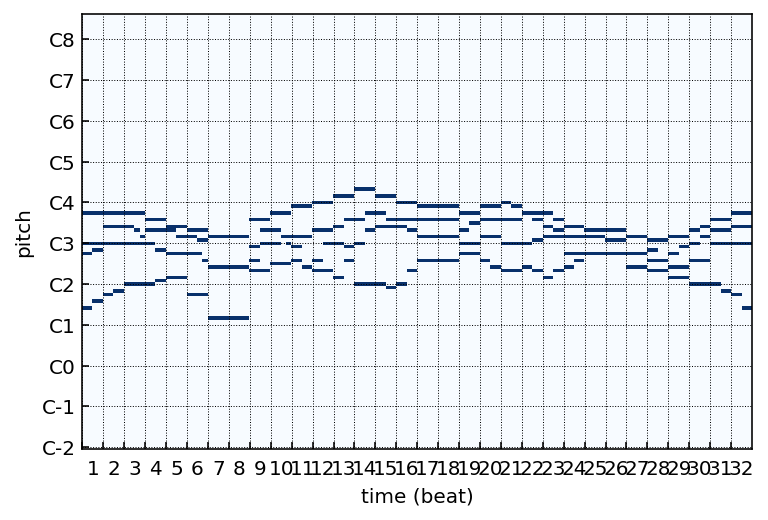

In [6]:
# Visualize A Random Piano roll
random_pianoroll = dataset_samples[randrange(len(dataset_samples))]
plot_pianoroll(pianoroll = random_pianoroll,
               beat_resolution = 4)

## Training Augmentation

The augmented **input piano roll** is created by adding and removing notes from the original piano roll. By keeping the original piano roll as the target, the model learns what edit events (i.e. notes to add and remove) are needed to recreate from the augmented piano roll. The augmented piano roll can represent a user input melody which has some mistakes / off-tune notes that need to be corrected. In this way, the model learns how to fix/improve the input.
During training, the data generator creates (input, target) pairs by applying augmentations on the piano rolls present in the dataset. In each epoch, different notes are added and removed from original piano rolls to form the augmented piano rolls (as these notes are added/removed in random pixels). This means that we will have a new set of augmented piano rolls for each epoch, and this effectively creates an unlimited input training dataset. 

There can be multiple augmented piano rolls for a single original piano roll, and this can be configured using the parameter - **“samples_per_ground_truth_data_item”** in **constants.py**. Details of adding and removing notes during augmentation are explained below.


## Removing Notes From The Original Piano Roll

Notes are randomly removed from the original piano roll to form the augmented piano roll. The model learns that it needs to add these notes in the augmented piano roll to recreate the original piano roll. This teaches the model how to fill in missing notes. The percentage of original notes to remove is determined by sampling from a uniform distribution between a lower and upper bound. The default lower bound of notes to remove is 0% as this helps the model learn that it doesn’t need to add notes to the input when the input is already “perfect”. The default upper bound is 100% as this helps the model create music when nothing is given as input (the unconditioned music generation case). 

![SegmentLocal](images/removenotes.gif "segment")

## Adding Notes To The Original Piano Roll 

Notes are randomly added to the original piano roll to form the augmented piano roll. The model learns that it needs to remove these notes in the augmented piano roll to recreate the original. This teaches the model how to remove unnecessary or off-tune notes. The percentage of extra notes to add is determined by sampling from a uniform distribution between a lower and upper bound (similar to the removing notes case). The default lower bound of notes to add is 0% of the current empty notes. This teaches the model to remove no notes when the input is already “perfect”. The default upper bound of notes to add is 1.5% of the current empty pixels (that do not have a note). This upper percentage may seem small, but since the percentage is out of the total empty pixels (which are usually far greater than the number of notes), the upper bound ends up being sufficiently large. 

![SegmentLocal](images/addnotes.gif "segment")

For both percentage of notes to add and remove, sampling is done from a uniform distribution to ensure that the model sees different potential states equally often. During training, this equal representation helps the model learn how to fill in or remove different numbers of notes, and how to recreate the original from any stage of the input. This is useful during the iterative inference process which we describe in more detail in the Inference section.

Both adding and removing notes is performed together on each piano roll. The sampling lower bound and sampling upper bound parameters for these can be changed via the parameters -  **“sampling_lower_bound_remove”**, **“sampling_upper_bound_remove”**, **“sampling_lower_bound_add”**, and **“sampling_upper_bound_add”**.


In [7]:
sampling_lower_bound_remove = 0
sampling_upper_bound_remove = 100
sampling_lower_bound_add = 1
sampling_upper_bound_add = 1.5

## Loss Function

Rather than using a traditional loss function such as binary crossentropy, we calculate a custom loss function for our model. In our augmentation we both add extraneous notes and remove existing notes from the piano roll. Our end goal is to have the model pick the next **edit event**(i.e. the next note to add or remove) so that we can take the input piano roll and bring it closer to the original piano roll, also known as the **target piano roll**. Notice that the model could pick any one of the extraneous or missing notes to bring the input piano roll closer to the target piano roll. These extraneous or missing notes is the **symmetric difference** between the input and target piano rolls. We can calculate the symmetric difference as the **exclusive-or** between the input and target piano rolls. Assuming that choosing any of the notes in the symmetric difference is equally likely, the model’s goal is to minimize the difference between its output and a uniform distribution for the probabilities of each of those notes. This difference in distributions can be calculated as the **Kullback–Leibler divergence**. Thus our loss function is the difference between the model’s output and the uniform distribution of all pixels/note probabilities in the symmetric difference.

In [8]:
# Customized Loss function
class Loss():
    @staticmethod
    def built_in_softmax_kl_loss(target, output):
        '''
        Custom Loss Function
        :param target: ground truth values
        :param output: predicted values
        :return kullback_leibler_divergence loss
        '''
        target = K.flatten(target)
        output = K.flatten(output)
        target = target / K.sum(target)
        output = K.softmax(output)
        return keras.losses.kullback_leibler_divergence(target, output)

## Model Architecture

Our Model architecture is adapted from the U-Net architecture (a popular CNN that is used extensively in the computer vision domain), consisting of an **“encoder”** that maps the single track music data (represented as piano roll images) to a relatively lower dimensional “latent space“ and a **”decoder“** that maps the latent space back to multi-track music data.

Here are the inputs provided to the generator:

**Single-track piano roll input**: A single melody track of size (128, 128, 1) => (TimeStep, NumPitches, NumTracks) is provided as the input to the model. 

Notice from the figure below that the encoding layers of the model on the left side and decoder layer on on the right side are connected to create a U-shape, thereby giving the name U-Net to this architecture.

<img src="images/unet.png" alt="Model architecture" width="800">

In [9]:
# Build The Model
class ArCnnModel():
    def __init__(self,
                 input_dim,
                 num_filters,
                 growth_factor,
                 num_layers,
                 dropout_rate_encoder,
                 dropout_rate_decoder,
                 batch_norm_encoder,
                 batch_norm_decoder,
                 learning_rate,
                 optimizer_enum,
                 pre_trained=None):

        # Piano roll Input Dimensions
        self.input_dim = input_dim
        # Number of filters in the convolution
        self.num_filters = num_filters
        # Growth rate of number of filters at each convolution
        self.growth_factor = growth_factor
        # Number of Encoder and Decoder layers
        self.num_layers = num_layers
        # A list of dropout values at each encoder layer
        self.dropout_rate_encoder = dropout_rate_encoder
        # A list of dropout values at each decoder layer
        self.dropout_rate_decoder = dropout_rate_decoder
        # A list of flags to ensure if batch_nromalization at each encoder
        self.batch_norm_encoder = batch_norm_encoder
        # A list of flags to ensure if batch_nromalization at each decoder
        self.batch_norm_decoder = batch_norm_decoder
        # Path to pretrained Model
        self.pre_trained = pre_trained
        # Learning rate for the model
        self.learning_rate = learning_rate
        # Optimizer to use while training the model
        self.optimizer_enum = optimizer_enum
        if self.num_layers < 1:
            raise ValueError(
                "Number of layers should be greater than or equal to 1")

    # Number of times Conv2D to be performed
    CONV_PER_LAYER = 2

    def down_sampling(self,
                      layer_input,
                      num_filters,
                      batch_normalization=False,
                      dropout_rate=0):
        '''
        :param: layer_input: Input Layer to the downsampling block
        :param: num_filters: Number of filters
        :param: batch_normalization: Flag to check if batch normalization to be performed
        :param: dropout_rate: To regularize overfitting
        '''
        encoder = layer_input
        for _ in range(self.CONV_PER_LAYER):
            encoder = Conv2D(num_filters, (3, 3),
                             activation='relu',
                             padding='same')(encoder)
            pooling_layer = MaxPooling2D(pool_size=(2, 2))(encoder)
            if dropout_rate:
                pooling_layer = Dropout(dropout_rate)(pooling_layer)
            if batch_normalization:
                pooling_layer = BatchNormalization()(pooling_layer)
        return encoder, pooling_layer

    def up_sampling(self,
                    layer_input,
                    skip_input,
                    num_filters,
                    batch_normalization=False,
                    dropout_rate=0):
        '''
        :param: layer_input: Input Layer to the downsampling block
        :param: num_filters: Number of filters
        :param: batch_normalization: Flag to check if batch normalization to be performed
        :param: dropout_rate: To regularize overfitting
        '''
        decoder = concatenate(
            [UpSampling2D(size=(2, 2))(layer_input), skip_input])
        if batch_normalization:
            decoder = BatchNormalization()(decoder)
        for _ in range(self.CONV_PER_LAYER):
            decoder = Conv2D(num_filters, (3, 3),
                             activation='relu',
                             padding='same')(decoder)

        if dropout_rate:
            decoder = Dropout(dropout_rate)(decoder)
        return decoder

    def get_optimizer(self, optimizer_enum, learning_rate):
        '''
        Use either Adam or RMSprop.
        '''
        if OptimizerType.ADAM == optimizer_enum:
            optimizer = Adam(lr=learning_rate)
        elif OptimizerType.RMSPROP == optimizer_enum:
            optimizer = RMSprop(lr=learning_rate)
        else:
            raise Exception("Only Adam and RMSProp optimizers are supported")
        return optimizer

    def build_model(self):
        # Create a list of encoder sampling layers
        down_sampling_layers = []
        up_sampling_layers = []
        inputs = Input(self.input_dim)
        layer_input = inputs
        num_filters = self.num_filters
        # encoder samplimg layers
        for layer in range(self.num_layers):
            encoder, pooling_layer = self.down_sampling(
                layer_input=layer_input,
                num_filters=num_filters,
                batch_normalization=self.batch_norm_encoder[layer],
                dropout_rate=self.dropout_rate_encoder[layer])

            down_sampling_layers.append(encoder)
            layer_input = pooling_layer  # Get the previous pooling_layer_input
            num_filters *= self.growth_factor

        # bottle_neck layer
        bottle_neck = Conv2D(num_filters, (3, 3),
                             activation='relu',
                             padding='same')(pooling_layer)
        bottle_neck = Conv2D(num_filters, (3, 3),
                             activation='relu',
                             padding='same')(bottle_neck)
        num_filters //= self.growth_factor

        # upsampling layers
        decoder = bottle_neck
        for index, layer in enumerate(reversed(down_sampling_layers)):
            decoder = self.up_sampling(
                layer_input=decoder,
                skip_input=layer,
                num_filters=num_filters,
                batch_normalization=self.batch_norm_decoder[index],
                dropout_rate=self.dropout_rate_decoder[index])
            up_sampling_layers.append(decoder)
            num_filters //= self.growth_factor

        output = Conv2D(1, 1, activation='linear')(up_sampling_layers[-1])
        model = Model(inputs=inputs, outputs=output)
        optimizer = self.get_optimizer(self.optimizer_enum, self.learning_rate)
        model.compile(optimizer=optimizer, loss=Loss.built_in_softmax_kl_loss)
        if self.pre_trained:
            model.load_weights(self.pre_trained)
        model.summary()
        return model


class OptimizerType(Enum):
    ADAM = "Adam"
    RMSPROP = "RMSprop"

## Training
We split the dataset into training and validation sets. The default training-validation split is 0.9, but this can be changed with the parameter **“training_validation_split”** in **constants.py**.

During training, the data generator creates (input, target) pairs by applying augmentations on the piano rolls present in the dataset. Details of the augmentation are described in the previous section. In each epoch, different notes will be added and removed from original piano rolls to form the augmented piano rolls (as these notes are added/removed in random spots each time). This means that we will have a new set of augmented piano rolls for each epoch, and this effectively creates an unlimited input training dataset. 


In [10]:
dataset_size = len(dataset_samples)
dataset_split = math.floor(dataset_size * Constants.training_validation_split)
print(0, dataset_split, dataset_split + 1, dataset_size)

training_samples = dataset_samples[0:dataset_split]
print("training samples length: {}".format(len(training_samples)))
validation_samples = dataset_samples[dataset_split + 1:dataset_size]
print("validation samples length: {}".format(len(validation_samples)))

0 683 684 759
training samples length: 683
validation samples length: 75


All the ArCnn model related hyperparameters can be changed from below. For instance, to decrease the model size, change the default value of num_layers from 5, and update the dropout_rate_encoder, dropout_rate_deoder, batch_norm_encoder and batch_norm_decoder lists accordingly.

In [11]:
# Piano Roll Input Dimensions
input_dim = (Constants.bars * Constants.beats_per_bar * Constants.beat_resolution, 
             Constants.number_of_pitches, 
             Constants.number_of_channels)
# Number of Filters In The Convolution
num_filters = 32
# Growth Rate Of Number Of Filters At Each Convolution
growth_factor = 2
# Number Of Encoder And Decoder Layers
num_layers = 5
# A List Of Dropout Values At Each Encoder Layer
dropout_rate_encoder = [0, 0.5, 0.5, 0.5, 0.5]
# A List Of Dropout Values At Each Decoder Layer
dropout_rate_decoder = [0.5, 0.5, 0.5, 0.5, 0]
# A List Of Flags To Ensure If batch_normalization Should be performed At Each Encoder
batch_norm_encoder = [True, True, True, True, False]
# A List Of Flags To Ensure If batch_normalization Should be performed At Each Decoder
batch_norm_decoder = [True, True, True, True, False]
# Path to Pretrained Model If You Want To Initialize Weights Of The Network With The Pretrained Model
pre_trained = False
# Learning Rate Of The Model
learning_rate = 0.001
# Optimizer To Use While Training The Model
optimizer_enum = OptimizerType.ADAM
# Batch Size
batch_size = 32
# Number Of Epochs
epochs = 500

In [12]:
# The Number of Batch Iterations Before A Training Epoch Is Considered Finsihed
steps_per_epoch = int(
    len(training_samples) * Constants.samples_per_ground_truth_data_item / int(batch_size))

print("The Total Number Of Steps Per Epoch Are: "+ str(steps_per_epoch))

# Total Number Of Time Steps
n_timesteps = Constants.bars * Constants.beat_resolution * Constants.beats_per_bar

The Total Number Of Steps Per Epoch Are: 170


## Build The Data Generators

Now let's build the training and validation data generators to create data on the fly during training.

In [13]:
## Training Data Generator
training_data_generator = PianoRollGenerator(sample_list=training_samples,
                                             sampling_lower_bound_remove = sampling_lower_bound_remove,
                                             sampling_upper_bound_remove = sampling_upper_bound_remove,
                                             sampling_lower_bound_add = sampling_lower_bound_add,
                                             sampling_upper_bound_add = sampling_upper_bound_add,
                                             batch_size = batch_size,
                                             bars = Constants.bars,
                                             samples_per_data_item = Constants.samples_per_ground_truth_data_item,
                                             beat_resolution = Constants.beat_resolution,
                                             beats_per_bar = Constants.beats_per_bar,
                                             number_of_pitches = Constants.number_of_pitches,
                                             number_of_channels = Constants.number_of_channels)

In [14]:
# Vaalidation Data Generator
validation_data_generator = PianoRollGenerator(sample_list = validation_samples,
                                               sampling_lower_bound_remove = sampling_lower_bound_remove,
                                               sampling_upper_bound_remove = sampling_upper_bound_remove,
                                               sampling_lower_bound_add = sampling_lower_bound_add,
                                               sampling_upper_bound_add = sampling_upper_bound_add,
                                               batch_size = batch_size, 
                                               bars = Constants.bars,
                                               samples_per_data_item = Constants.samples_per_ground_truth_data_item,
                                               beat_resolution = Constants.beat_resolution,
                                               beats_per_bar = Constants.beats_per_bar, 
                                               number_of_pitches = Constants.number_of_pitches,
                                               number_of_channels = Constants.number_of_channels)

## Create Callbacks for the model. 
1. Create **Training Vs Validation** loss plots during training.
2. Save model checkpoints based on the **Best Validation Loss**.

In [15]:
# Callback For Loss Plots 
plot_losses = GenerateTrainingPlots()
## Checkpoint Path
checkpoint_filepath =  'checkpoints/-best-model-epoch:{epoch:04d}.hdf5'

# Callback For Saving Model Checkpoints 
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Create A List Of Callbacks
callbacks_list = [plot_losses, model_checkpoint_callback]

In [16]:
# Create A Model Instance
MusicModel = ArCnnModel(input_dim = input_dim,
                        num_filters = num_filters,
                        growth_factor = growth_factor,
                        num_layers = num_layers,
                        dropout_rate_encoder = dropout_rate_encoder,
                        dropout_rate_decoder = dropout_rate_decoder,
                        batch_norm_encoder = batch_norm_encoder,
                        batch_norm_decoder = batch_norm_decoder,
                        pre_trained = pre_trained,
                        learning_rate = learning_rate,
                        optimizer_enum = optimizer_enum)

In [17]:
model = MusicModel.build_model()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0

In [18]:
# Start Training
history = model.fit_generator(training_data_generator,
                              validation_data = validation_data_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs = epochs,
                              callbacks = callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/500
170/170 [==============================] - 126s 738ms/step - loss: 1.2398 - val_loss: 0.9068
Epoch 2/500
 21/170 [==>...........................] - ETA: 1:30 - loss: 0.9320

KeyboardInterrupt: 

## Inference 

## Generating Bach Like Enhanced Melody For Custom Input

Congratulations! You have trained your very own AutoRegressive model to generate music. Let us see how our music model performs on a custom input.

Before loading the model, we need to load inference related parameters. After that, we load our pretrained model and generate a new melody based on **"Twinkle Twinkle Little Star"**.

Inference is done by sampling from the model’s predicted probability distribution across the entire piano roll. It is an iterative process, and a note is added or removed to the input in every iteration via sampling. After adding or removing a note to the input in an iteration, this new input is fed back into the model. The model is trained to both remove and add notes, and it can improve the input melody, and can correct mistakes that it may have made in earlier iterations as well.

You can change certain inference parameters to observe the differences in the generated music as described below.  
* **Sampling iterations** - his specifies the number of iterations during inference. Larger number of sampling iterations can ensure that the model has had enough time to improve the input melody and also correct any mistakes it may have made along the way. Beyond a certain number of sampling iterations, it can be observed that the model keeps adding notes and then removing those notes in a subsequent iterations or vice-versa. This implies that convergence has been reached.
* **Maximum Notes to Remove** - This specifies the maximum percentage of notes of the original input melody that can be removed during inference. If you choose this to be 0%, then none of your original melody will be removed during inference. 
* **Maximum Notes to Add** - This specifies the maximum number of new notes to add to the original input melody during inference.With the “Maximum Notes to Remove” and “Maximum Notes to Add”, you can choose the degree to which you would like to preserve your original input melody. However, by restricting the model’s ability to add or remove notes, you may risk losing some music quality. 
* **Creativity**- The output probability distribution generated by the model is obtained via softmax, and you can change the temperature for softmax to get different levels of “creativity”. By using lower temperatures, the output probability distribution would have more distinct peaks, and the model would be more confident in its predictions. By using higher temperatures, the output probability distribution would be flatter, and the model would have a higher chance of choosing less likely notes to add/remove. By increasing the temperature, you can give the model the ability to take more risks, and increase its “creativity”.


Let us first load our last saved or pretrained checkpoint and inference related parameters. To modify the inference related parameters, please navigate to **inference_parameters.json** and change the values in the json file.

In [19]:
# Load The Inference Related Parameters
with open('inference_parameters.json') as json_file:
    inference_params = json.load(json_file)

In [21]:
# Create An Inference Object
inference_obj = Inference()
# Load The Checkpoint
inference_obj.load_model('checkpoints/-best-model-epoch:0001.hdf5')


Please navigate to **sample_inputs** directory to find different input melodies we have already created for you to help generating novel compositions.

To download the novel compositions, you have created using the model we just trained, please navigate to **outputs** directory and download the midi file.

In [22]:
# Generate The Composition
inference_obj.generate_composition('sample_inputs/twinkle_twinkle.midi', inference_params)

## Now, Let's Play The Generated Output And Listen To It

In [23]:
play_midi("outputs/output_0.mid")

## Evaluate Results

Now that we have finished generating our enhanced melody, let's find out how we did. We will analyze our output using below three metrics and compare them with the sample input:

- **Empty Bar Rate:** The ratio of empty bars to total number of bars.
- **Pitch Histogram Distance:** A metric that captures the distribution and position of pitches.
- **In Scale Ratio:** Ratio of the number of notes that are in C major key, which is a common key found in music, to the total number of notes. 

After computing the metrics, let's also visualize the input piano roll and compare it with the generated output piano roll to notice the notes added.


In [24]:
# Input Midi Metrics:
print("The input midi metrics are:")
get_music_metrics("sample_inputs/twinkle_twinkle.midi", beat_resolution=4)

print("\n")
# Generated Output Midi Metrics:
print("The generated output midi metrics are:")
get_music_metrics("outputs/output_0.mid", beat_resolution=4)

The input midi metrics are:
+----------------------+---------------+-----------------+----------------+
| n_pitch_classes_used | in_scale_rate | polyphonic_rate | n_pitches_used |
+======================+===============+=================+================+
| 3                    | 0             | 10              | 50.811         |
+----------------------+---------------+-----------------+----------------+


The generated output midi metrics are:
+----------------------+---------------+-----------------+----------------+
| n_pitch_classes_used | in_scale_rate | polyphonic_rate | n_pitches_used |
+======================+===============+=================+================+
| 5                    | 0.289         | 25              | 44.650         |
+----------------------+---------------+-----------------+----------------+


In [25]:
# Convert The Input and Generated Midi To Tensors
input_pianoroll = process_midi("sample_inputs/twinkle_twinkle.midi", beat_resolution=4)
output_pianoroll = process_midi("outputs/output_0.mid", beat_resolution=4)

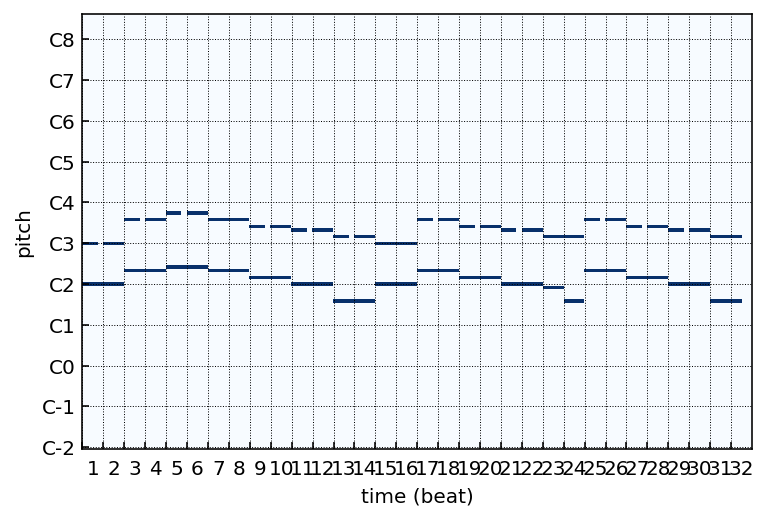

In [26]:
# Plot Input Piano Roll
plot_pianoroll(input_pianoroll, beat_resolution=4)

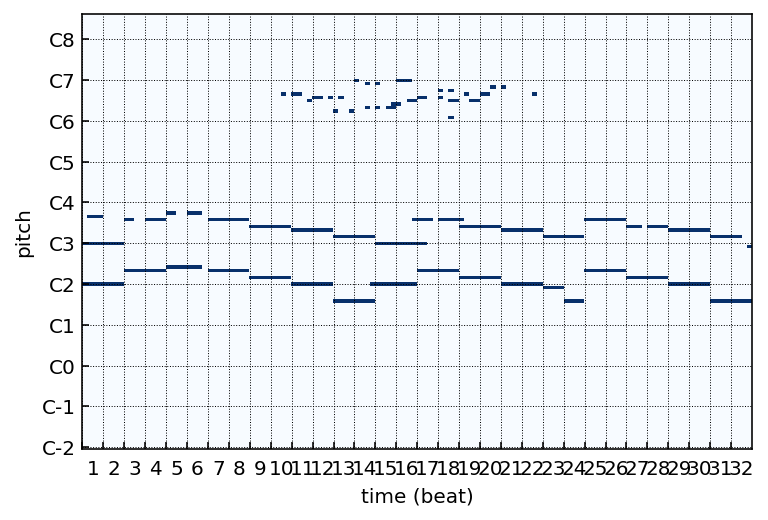

In [27]:
# Plot Output Piano Roll
plot_pianoroll(output_pianoroll, beat_resolution=4)

## Appendix

## Open Source Implementations
For more open-source implementations of generative models for music, check out:

- [MuseNet](https://openai.com/blog/musenet/): Uses GPT2, a large-scale Transformer model to predict the next token in sequence
- [Jukebox](https://openai.com/blog/jukebox/): Uses various neural nets to generate music, including rudimentary singing, as raw audio in a variety of genres and artist styles.
- [Music Transformer](https://github.com/tensorflow/magenta/tree/master/magenta/models/score2perf): Uses transformers to generate music!

## References

<a id='references'></a>
1. [MuseGAN: Multi-track Sequential Generative Adversarial Networks for Symbolic Music Generation and Accompaniment.](https://arxiv.org/abs/1709.06298)
2. [MidiNet: A Convolutional Generative Adversarial Network for Symbolic-domain Music Generation.](https://arxiv.org/abs/1703.10847)
3. [A Hierarchical Recurrent Neural Network for Symbolic Melody Generation.](https://pubmed.ncbi.nlm.nih.gov/31796422/)
4. [Counterpoint by Convolution](https://arxiv.org/abs/1903.07227)
5. [MusicTransformer:Generating Music With Long-Term Structure](https://arxiv.org/abs/1809.04281)
6. [Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/abs/1606.05328)
7. [Neural Autoregressive Distribution Estimation](https://arxiv.org/abs/1605.02226)
